---

## Khmer Sentiment Analysis with BERT Feature Extraction Based Approach
---

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import re
import numpy as np
import pandas as pd
import collections
import tensorflow as tf
import tensorflow_hub as hub

import warnings
warnings.filterwarnings('ignore')

### Load Pre-trained BERT module for khmer

In [18]:
!unzip "/content/drive/bert_module_khmer.zip" -d "./pretrained"

Archive:  /content/drive/My Drive/Colab Notebooks/Khmer Paper/bert_module_khmer.zip
   creating: ./pretrained/bert_module_khmer/
   creating: ./pretrained/bert_module_khmer/assets/
  inflating: ./pretrained/bert_module_khmer/assets/bert_config.json  
  inflating: ./pretrained/bert_module_khmer/assets/vocab_file_BERT_.txt  
  inflating: ./pretrained/bert_module_khmer/saved_model.pb  
  inflating: ./pretrained/bert_module_khmer/tfhub_module.pb  
   creating: ./pretrained/bert_module_khmer/variables/
  inflating: ./pretrained/bert_module_khmer/variables/variables.data-00000-of-00001  
  inflating: ./pretrained/bert_module_khmer/variables/variables.index  


### Load Train/Validation Data

In [ ]:
data = pd.read_excel("/content/drive/sentiment_analysis_data_km.xlsx", encoding="UTF-8")

In [4]:
data['text_prep'] = data['text_prep'].apply(lambda x: ' '.join(re.sub(r'[០១២៣៤៥៦៧៨៩។៕៖ៗ៘៙៚]+', ' ', x).strip().split()))
data.drop_duplicates(subset=['text_prep'], inplace=True)
data.head()

,source,texts,texts_km,text_prep,sentiment
0,Yelp,Wow... Loved this place.,អីយ៉ា ... ស្រឡាញ់កន្លែងនេះ។,អីយ៉ា ស្រឡាញ់ កន្លែង នេះ,1
1,Yelp,Crust is not good.,សំបកគឺជាការមិនល្អ។,សំបក គឺ ជា ការ មិន ល្អ,0
2,Yelp,Not tasty and the texture was just nasty.,មិនហ៊ាននិងវាយនភាពនេះគឺអាក្រក់គ្រាន់តែជា។,មិន ហ៊ាន និង វាយន ភាព នេះ គឺ អាក្រក់ គ្រាន់ តែ ជា,0
3,Yelp,Stopped by during the late May bank holiday of...,បញ្ឈប់ដោយក្នុងអំឡុងពេលថ្ងៃឈប់សម្រាកចុងខែឧសភាបិ...,បញ្ឈប់ ដោយ ក្នុង អំឡុង ពេល ថ្ងៃ ឈប់ សម្រាក ចុង...,1
4,Yelp,The selection on the menu was great and so wer...,ការជ្រើសនៅលើម៉ឺនុយនេះគឺអស្ចារ្យណាស់ហើយត្រូវបាន...,ការ ជ្រើស នៅ លើ ម៉ឺនុយ នេះ គឺ អស្ចារ្យ ណាស់ ហើ...,1


In [5]:
data = data.reset_index()

In [6]:
data.shape

(10710, 6)

In [7]:
data['sentiment'].value_counts()

1    5367
0    5343
Name: sentiment, dtype: int64

### Load Test Data

In [ ]:
# Load Test Data
data_test = pd.read_excel("/content/sentiment_analysis_test_data.xlsx")

In [ ]:
data_test['X_test'] = data_test['X_test'].apply(lambda x: ' '.join(re.sub(r'[០១២៣៤៥៦៧៨៩។៕៖ៗ៘៙៚]+', ' ', x).strip().split()))

In [ ]:
data_test.head()

,texts,X_test,y_test
0,ខ្ញុំត្រូវចាកចេញពីការងារ នឹងមិនអាចទៅរួចទេ។ ដូច...,ខ្ញុំ ត្រូវ ចាក ចេញ ពី ការងារ នឹង មិន អាច ទៅ រ...,0
1,សួស្តី។ យើងកំពុងហោះហើរ SWA ថ្ងៃនេះ។ កូនប្រុសរប...,សួស្តី យើង កំពុង ហោះ ហើរ ថ្ងៃ នេះ កូន ប្រុស រប...,0
2,សម្លៀកបំពាក់នេះមើលទៅហើយមានអារម្មណ៍ថាថោក។ សម្ភា...,សម្លៀកបំពាក់ នេះ មើល ទៅ ហើយ មាន អារម្មណ៍ ថា ថោ...,0
3,ធំពេកហើយវាមិនមានសុវត្ថិភាពគ្រប់គ្រាន់ពាក់សម្រា...,ធំ ពេក ហើយ វា មិន មាន សុវត្ថិ ភាព គ្រប់ គ្រាន់...,0
4,តើអ្នកដឹងទេនៅពេលផ្លូវថ្មីពី HOU ទៅ Aruba &amp ...,តើ អ្នក ដឹង ទេ នៅ ពេល ផ្លូវ ថ្មី ពី ទៅ នឹង អាច...,0


In [16]:
data_test.y_test.value_counts()

0    209
1    191
Name: y_test, dtype: int64

### Data Partitioning

In [8]:
X = data['text_prep']
y = data['sentiment']

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle=True, stratify=y)
X_test, y_test = data_test.X_test, data_test.y_test

print("""Training shape: {}
Validation shape: {}
Test shape: {}""".format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

Training shape: 8568
Validation shape: 2142
Test shape: 400


### Tokenizer

In [19]:
def convert_to_unicode(text):
    """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
    if isinstance(text, str):
        return text
    elif isinstance(text, bytes):
        return text.decode("utf-8", "ignore")
    else:
        raise ValueError("Unsupported string type: %s" % (type(text)))

def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    index = 0
    with tf.gfile.GFile(vocab_file, "r") as reader:
        while True:
            token = convert_to_unicode(reader.readline())
            if not token:
                break
            token = token.strip()
            vocab[token] = index
            index += 1
    return vocab

def convert_by_vocab(vocab, items):
    """Converts a sequence of [tokens|ids] using the vocab."""
    output = []
    for item in items:
        try:
            output.append(vocab[item])
        except:
            pass
    return output

class FullTokenizer(object):
    """Runs end-to-end tokenziation."""

    def __init__(self, vocab_file, do_lower_case=False):
        self.vocab = load_vocab(vocab_file)

    def tokenize(self, text):
        """Runs basic whitespace cleaning and splitting on a piece of text."""
        text = text.strip()
        if not text:
            return []
        tokens = text.split()
        return tokens

    def convert_tokens_to_ids(self, tokens):
        return convert_by_vocab(self.vocab, tokens)

In [20]:
vocab_path = '/content/pretrained/bert_module_khmer/assets/vocab_file_BERT_.txt'
tokenizer = FullTokenizer(vocab_file=vocab_path, do_lower_case=True)

### BERT Input Generator

In [21]:
def convert_sentence_to_features(sentence, tokenizer, max_seq_len):
    tokens = ['[CLS]']
    tokens.extend(tokenizer.tokenize(sentence))
    if len(tokens) > max_seq_len-1:
        tokens = tokens[:max_seq_len-1]
    tokens.append('[SEP]')
    
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)
    segment_ids = [0] * len(input_ids)
    
    zero_padding = [0] * (max_seq_len-len(input_ids))

    input_ids.extend(zero_padding)
    input_mask.extend(zero_padding)
    segment_ids.extend(zero_padding)
    
    return input_ids, input_mask, segment_ids

def convert_sentences_to_features(sentences, tokenizer, max_seq_len=64):
    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    
    for sentence in sentences:
        input_ids, input_mask, segment_ids = convert_sentence_to_features(sentence, tokenizer, max_seq_len)
        all_input_ids.append(input_ids)
        all_input_mask.append(input_mask)
        all_segment_ids.append(segment_ids)
    
    return all_input_ids, all_input_mask, all_segment_ids

### Load BERT Pre-trained Module

In [22]:
BERT_URL = '/content/pretrained/bert_module_khmer'
module = hub.Module(BERT_URL)

### Feature Extractor

In [23]:
def creat_BERT_embeddings(sentences):
    """Create BERT Embeddings from tokenized Text

    Argument: A list of Sentences
    Return: A numpy array of BERT embeddings
    """
    input_ids_vals, input_mask_vals, segment_ids_vals = convert_sentences_to_features(sentences, tokenizer, 64)

    ### SIGNATURE
    input_ids = tf.placeholder(dtype=tf.int32, shape=[None, None])
    input_mask = tf.placeholder(dtype=tf.int32, shape=[None, None])
    segment_ids = tf.placeholder(dtype=tf.int32, shape=[None, None])

    bert_inputs = dict(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids)
    
    bert_outputs = module(bert_inputs, signature="tokens", as_dict=True)

    pooled_embeddings = []
    # sequence_embeddings = []

    ### CREAT BATCH PROCESS
    input_ids_tensors = tf.compat.v1.data.Dataset.from_tensor_slices(input_ids_vals)
    input_mask_tensors = tf.compat.v1.data.Dataset.from_tensor_slices(input_mask_vals)
    segment_ids_tensors = tf.compat.v1.data.Dataset.from_tensor_slices(segment_ids_vals)
    dcombined = tf.compat.v1.data.Dataset.zip((input_ids_tensors, input_mask_tensors, segment_ids_tensors)).batch(512)

    iterator = tf.compat.v1.data.make_one_shot_iterator(dcombined)
    next_ele = iterator.get_next()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        try:
            while True:
                inputs = sess.run(next_ele)

                input_ids_vals = inputs[0]
                input_mask_vals = inputs[1]
                segment_ids_vals = inputs[2]
                out = sess.run(bert_outputs, feed_dict={input_ids: input_ids_vals,
                                                        input_mask: input_mask_vals, 
                                                        segment_ids: segment_ids_vals})

                pooled_embeddings.extend(out['pooled_output'].tolist())
                # sequence_embeddings.extend(out['sequence_output'].tolist())
        except tf.errors.OutOfRangeError:
            pass
    return np.array(pooled_embeddings)

In [24]:
%%time
X_train_embeddings = pd.DataFrame(creat_BERT_embeddings(X_train)).add_prefix('Col_')
X_val_embeddings = pd.DataFrame(creat_BERT_embeddings(X_val)).add_prefix('Col_')
X_test_embeddings = pd.DataFrame(creat_BERT_embeddings(X_test)).add_prefix('Col_')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
CPU times: user 29.6 s, sys: 12.3 s, total: 42 s
Wall time: 47.7 s


### Model Architecture

In [ ]:
import random as rn

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import History
from keras.optimizers import Adam, SGD

In [ ]:
from keras.utils import to_categorical

y_train_k = to_categorical(y_train, num_classes=2)
y_val_k = to_categorical(y_val, num_classes=2)
y_test_k = to_categorical(y_test, num_classes=2)

In [69]:
np.random.seed(2)
rn.seed(3)

history = History()

model = Sequential()
model.add(Dense(units = 1024, activation = "tanh", input_dim=768))
model.add(Dropout(0.1))
model.add(Dense(units = 512, activation = "tanh"))
model.add(Dropout(0.1))
model.add(Dense(units = 256, activation = "tanh"))
model.add(Dropout(0.1))
model.add(Dense(units = 256, activation = "tanh"))
# model.add(Dropout(0.1))
model.add(Dense(units = 2, activation = "softmax"))

model.compile(optimizer=Adam(0.001), loss="categorical_crossentropy", metrics=['accuracy'])

model.fit(np.array(X_train_embeddings), np.array(y_train_k), 
          validation_data=(np.array(X_val_embeddings), np.array(y_val_k)), 
          epochs=52, 
          batch_size=3000, 
          shuffle=True, 
          callbacks=[history], 
          verbose=True)

Train on 8568 samples, validate on 2142 samples
Epoch 1/52
8568/8568 [==============================] - 1s 135us/step - loss: 2.3333 - accuracy: 0.5016 - val_loss: 1.7929 - val_accuracy: 0.5009
Epoch 2/52
8568/8568 [==============================] - 0s 14us/step - loss: 1.2129 - accuracy: 0.4987 - val_loss: 1.0117 - val_accuracy: 0.5028
Epoch 3/52
8568/8568 [==============================] - 0s 14us/step - loss: 0.8491 - accuracy: 0.5011 - val_loss: 0.8412 - val_accuracy: 0.4991
Epoch 4/52
8568/8568 [==============================] - 0s 15us/step - loss: 0.7796 - accuracy: 0.5030 - val_loss: 0.7119 - val_accuracy: 0.5023
Epoch 5/52
8568/8568 [==============================] - 0s 14us/step - loss: 0.7482 - accuracy: 0.5002 - val_loss: 0.6927 - val_accuracy: 0.5023
Epoch 6/52
8568/8568 [==============================] - 0s 14us/step - loss: 0.7152 - accuracy: 0.5090 - val_loss: 0.7389 - val_accuracy: 0.4991
Epoch 7/52
8568/8568 [==============================] - 0s 14us/step - loss: 0.71

In [70]:
# for learning curve
his_train_loss = history.history['loss']
his_val_loss = history.history['val_loss']

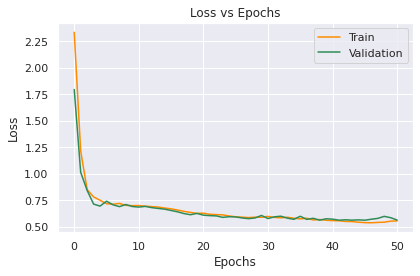

In [86]:
## plot learning curve
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(10,5))
plt.plot(his_train_loss,'darkorange')
plt.plot(his_val_loss, 'seagreen')

plt.title("Loss vs Epochs", fontdict={'fontsize': 12})
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig("sentiment_loss_vs_epochs_BERT_feature_based.jpg", dpi=300, bbox_inches='tight')
plt.show()

### Test

In [72]:
loss, test_accuracy = model.evaluate(np.array(X_test_embeddings), np.array(y_test_k), verbose=0)

In [110]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

accuracy_table = pd.DataFrame([round(train_accuracy, 3), round(val_accuracy, 3), round(test_accuracy, 3)], 
             index=['Training', 'Validation', 'Test'], 
             columns=['Accuracy'])
accuracy_table

,Accuracy
Training,0.732
Validation,0.713
Test,0.697


### Prediction

In [87]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [88]:
y_pred = model.predict(np.array(X_test_embeddings))
ac = accuracy_score(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))
print("Test Accuracy:", round(ac, 2))

Test Accuracy: 0.7


In [ ]:
## generate confusion matrix
cm = confusion_matrix(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))

In [97]:
print("Confusion Matrix: ")
p = pd.DataFrame(cm, 
                 index=[['Actual']*2, ['Negative', 'Positive']], 
                 columns=[['Predicted']*2,['Negative', 'Positive']])

p.style.set_properties(**{'background-color': 'lightgrey', 
                          'color': 'black'})

Confusion Matrix: 


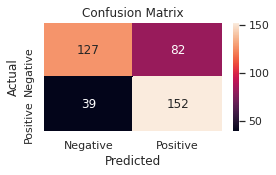

In [101]:
## Confusion Matrix in Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
p = pd.DataFrame(cm, 
                 index = ['Negative', 'Positive'],
                 columns = ['Negative', 'Positive'])

plt.figure(figsize=(4, 2))
sns.set()
f = sns.heatmap(p, annot=True, fmt="d")
plt.title("Confusion Matrix", fontdict={'fontsize': 12})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# f.get_figure().savefig("sentiment_confusion_matrix_BERT_feature_based.jpg", dpi=300, bbox_inches='tight')

In [108]:
## Classification Report
target_names = ['Negative', 'Positive']
print(classification_report(y_test.tolist(), y_pred.argmax(axis=1), target_names = target_names))

              precision    recall  f1-score   support

    Negative       0.77      0.61      0.68       209
    Positive       0.65      0.80      0.72       191

    accuracy                           0.70       400
   macro avg       0.71      0.70      0.70       400
weighted avg       0.71      0.70      0.70       400

